# New Section

**A Generative Adversarial Network (GAN)** is a powerful class of artificial neural networks used in machine learning and computer vision. GAN is a type of deep learning model composed of two neural networks: a generator and a discriminator, which compete against each other. The generator tries to create fake data (e.g., images) that mimic real data, while the discriminator attempts to distinguish between real and fake data.

Image colorization is a computer vision task that involves adding color to grayscale or black-and-white images. It's a fascinating application that can bring old photos to life, aid in medical imaging, or enhance visual content in various domains. Using a Generative Adversarial Network (GAN) for image colorization is a popular and effective approach.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Importing Necessary Libraries

In [2]:
!pip install torchsummary colour-science

In [3]:
import os
import numpy as np
import seaborn as sns  ## For data visualization library based on Matplotlib
import random
import matplotlib.pyplot as plt ## For graphing data


import torch ## PyTorch is a popular deep learning library
import torch.nn as nn
import torch.nn.functional as F

import torchvision ## Provide tools for image processing and datasets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torchsummary import summary  ##  Provide summary of a PyTorch model, showing the input/output shapes and number of parameters in each layer

from PIL import Image ## Provides functionality to open, manipulate, and save images

from typing import List

from tqdm.notebook import tqdm ## Progress bar tool to visualize loops and tasks


from colour import sRGB_to_XYZ, XYZ_to_Lab, Lab_to_XYZ, XYZ_to_sRGB ## A module contains color space conversion functions

import gc ## A garbage collection module in Python to speed up the GPU

/usr/local/lib/python3.10/dist-packages/colour/utilities/verbose.py:265: ColourWarning: "vaab/colour" was detected in "sys.path", please define a "COLOUR_SCIENCE__COLOUR__IMPORT_VAAB_COLOUR=True" environment variable to import its objects into "colour" namespace!
  warn(*args, **kwargs)  # noqa: B028


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
print(device)

cuda


## Preprocessing

Converting LAB color images (represented as separate L[grayscale] and a* b* [green_red and yellow_blue] channels) into RGB images.

In [6]:
def lab_to_rgb(L, ab, device):

    ## Takes a batch of images

    L = 100 * L  ## L color space typically ranges from 0 to 100
    ab = (ab - 0.5) * 256  ##  a*b* channels are scaled from the range 0 to approximately 256
    ##  Image tensor is permuted so that the shape changes from (batch_size, channels, height, width) to (batch_size, height, width, channels)
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).detach().cpu().numpy()  ## Concatenate L and ab channels
    rgb_imgs = []
    for img in Lab:
        img = Lab_to_XYZ(img)
        img = XYZ_to_sRGB(img)
        rgb_imgs.append(img)
    return torch.tensor(np.stack(rgb_imgs, axis=0)).permute(0, 3, 1, 2).to(device)  ## Convert back to  PyTorch tensor

 A transformation pipeline made using *'torchvision.transforms'* to preprocess images before they are passed into a neural network. ormalization helps speed up training and improve convergence by stabilizing the input to the network.

In [7]:
image_size = (384, 384)

t = transforms.Compose([
    transforms.Resize(image_size, antialias=True),  ## Resizes the input image to the specified size (384, 384)
    transforms.Normalize(mean=0, std=0.5)   ## Normalizes the image pixel values by subtracting the mean and dividing by the standard deviation for each pixel
])

A custom PyTorch dataset used for loading images for a colorization task. It processes images by converting them into LAB format and returns the L (lightness) and ab (color information) channels separately for use in the GAN model.

In [8]:
class ImageColorizeDataset(Dataset):
    def __init__(self, path: str, device='cpu', train: bool = False, transforms = None ):
        _mode = 'train' if train else 'test'

        self.device = device
        self._input_path = os.path.join(path, f'{_mode}_color')

        self.data = os.listdir(self._input_path)

        self.transforms = transforms

    def __len__(self):
        return len(self.data)


    def __getitem__(self, idx: int):
        to_tensor = transforms.ToTensor()

        item = self.data[idx]

        input_ = Image.open(os.path.join(self._input_path, item))

        input_ = to_tensor(input_)

        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        if self.transforms is not None:
            input_ = self.transforms(input_)

        img = input_.permute(1, 2, 0).numpy()
        img = sRGB_to_XYZ(img)
        img = XYZ_to_Lab(img).transpose(2, 0, 1).astype("float32")

        L = torch.tensor(img[[0], ...] / 100)
        ab = torch.tensor(img[[1, 2], ...] / 256 + 0.5)

        return L.to(device), ab.to(device)

*DataLoader* loads batches of 8 images at a time, apply transformations (resizing and normalization), and shuffle the order of the images to prevent any biases for train and test data.

In [9]:
test_data = ImageColorizeDataset("/content/drive/MyDrive/Colab Notebooks/data", transforms=t, train=False)
test_dl = DataLoader(test_data, batch_size=8, shuffle=True)

In [10]:
train_data = ImageColorizeDataset("/content/drive/MyDrive/Colab Notebooks/data", transforms=t, train=True)
train_dl = DataLoader(train_data, batch_size=8, shuffle=True)

Visualization for a batch of images from the training dataset, showing both the original grayscale images (L channel) and their corresponding colorized versions (after being converted from LAB to RGB format).

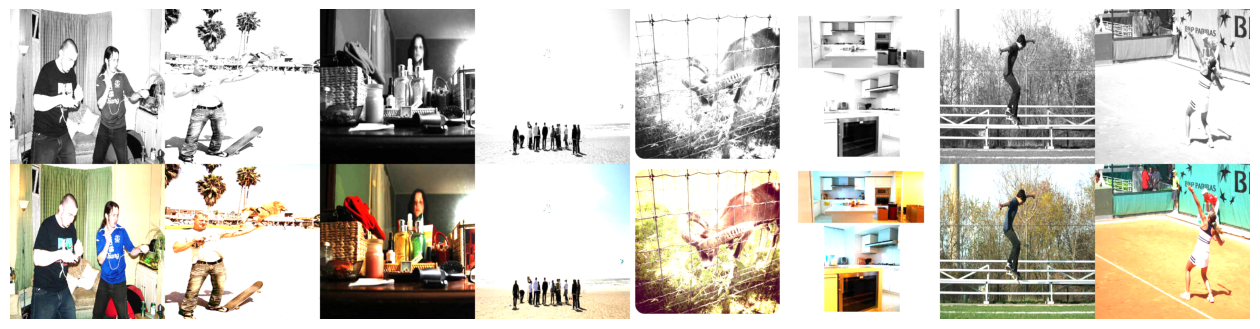

In [11]:
images, targets = next(iter(train_dl))

to_show = lab_to_rgb(images, targets, device=device)

## To show a batch of images into a grid for easy visualization
grid = torchvision.utils.make_grid(torch.cat([images.expand(to_show.shape), to_show], dim=0), nrow=8, padding=0, scale_each=True)

fig = plt.figure(figsize=(16,8))
plt.imshow(grid.cpu().permute(1,2,0)) ## Moves the grid of images to the CPU if they were on the GPU
plt.axis('off')
plt.show()

## Generator

UNet model is used as a generator.

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, norm_layer = nn.BatchNorm2d):
        super().__init__()


        self.block = nn.Sequential(
            ## First 3x3 convolution layer with padding and batch normalization, followed by ReLU
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            ## First 3x3 convolution layer with padding and batch normalization, followed by ReLU
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
        ## Identifying residual connection part, which helps the network learn more efficiently
        self.identity = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):

        x_ = x.detach().clone()

        x_ = self.block(x_)

        residual = self.identity(x) ##  Original input passes through the residual connection to match with  the shape of the output

        out = x_ + residual  ## Here addition is the key to the residual learning mechanism used in ResNet-like architectures

        return self.relu(out)  ## ReLU activation is applied to the sum of the block's output and the residual

Here two important building blocks for a U-Net-like architecture: an EncoderBlock and a DecoderBlock are used in models for tasks like image colorization, where the model needs to both compress information (encode) and then reconstruct (decode) it.

In [13]:
class EncoderBlock(nn.Module):    ## Class for compressing the spatial dimensions of the input while capturing its important features.
    def __init__(self, in_chans, out_chans, sampling_factor=2):
        super().__init__()
        self.block = nn.Sequential(
            nn.MaxPool2d(sampling_factor), ## Max-pooling layer that downscales the input
            ConvBlock(in_chans, out_chans) ## Extracts high-level features from the downsampled input
        )

    def forward(self, x):
        return self.block(x)

class DecoderBlock(nn.Module):  ## Class for reconstructing the spatial dimensions (upsampling) while fusing low-level features from the encoder
    def __init__(self, in_chans, out_chans, sampling_factor=2):
        super().__init__()
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

        self.block = ConvBlock(in_chans + out_chans, out_chans)

    def forward(self, x, skip):
        x  = self.upsample(x)
        ## Upsampled output is concatenated with the corresponding feature map from the encoder (skip connection) along the channel dimension
        x = torch.cat([x, skip], dim=1)
        x = self.block(x)
        return x


U-Net implementation is a powerful architecture for tasks requiring precise localization and segmentation, making it well-suited for applications like medical image segmentation or colorization.

In [19]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, dropout_rate=0.2):
        super().__init__()

        self.encoder = nn.ModuleList([    ##  Reduce the spatial dimensions and increase the depth of the feature maps
            ConvBlock(in_channels, 64),   ##  Channel = garyscale
            EncoderBlock(64, 128),
            EncoderBlock(128, 256),
            EncoderBlock(256, 512),

        ])
        self.decoder = nn.ModuleList([
            DecoderBlock(512, 256),
            DecoderBlock(256, 128),
            DecoderBlock(128, 64)
        ])

        self.dropout = nn.Dropout2d(dropout_rate)

        self.logits = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)

    def forward(self, x):


        encoded = []
        for enc in self.encoder:
            x = enc(x)
            x = self.dropout(x)
            encoded.append(x)

        enc_out = encoded.pop()

        for dec in self.decoder:
            enc_out = encoded.pop()
            x = dec(x, enc_out)
        return F.sigmoid(self.logits(x))
## sigmoid activation functionis applied to produce probabilities for each pixel

In [15]:
gc.collect()

0

## **Discriminator**

A discriminator network used in GAN, is designed to classify whether a given patch of an image is real or fake, contributing to the adversarial training process.

In [16]:
class PatchGAN(nn.Module):
    def __init__(self, in_channels, n_features=64, n_layers=3):
        super().__init__()


        k_size = 4
        p_size = 1
        ##  2D convolution with specified kernel size, padding, and stride
        ##  Leaky ReLU activation function with a negative slope
        seq = [nn.Conv2d(in_channels=in_channels, out_channels=n_features, kernel_size=k_size, padding=p_size, stride=2), nn.LeakyReLU(0.2, True)]

        f_mult = 1
        f_mult_prev = 1

        for i in range(1, n_layers):

            f_mult_prev = f_mult
            f_mult = min(2 ** i, 8)

            seq.append(nn.Conv2d(in_channels=f_mult_prev * n_features, out_channels=f_mult * n_features, kernel_size=k_size, padding=p_size, stride=2))
            seq.append(nn.BatchNorm2d(f_mult * n_features))
            seq.append(nn.LeakyReLU(0.2, True))

        f_mult_prev = f_mult
        f_mult = min(2 ** n_layers, 8)
            ## Multiplier for the number of feature channels, starts at 1 and doubles each layer until a maximum of 8.
        seq += [
            nn.Conv2d(n_features * f_mult_prev, n_features * f_mult, kernel_size=k_size, stride=1, padding=p_size),
            nn.BatchNorm2d(n_features * f_mult),
            nn.LeakyReLU(0.2, True)
        ]

        seq += [nn.Conv2d(n_features * f_mult, 1, kernel_size=k_size, stride=1, padding=p_size)]  # output 1 channel prediction map
        self.model = nn.Sequential(*seq)


    def forward(self, x, label):

        x = torch.cat((x, label), dim=1)
        x = self.model(x)
        return x

Here PatchGAN discriminator is used in conjunction with the generator network to form a GAN, where the generator creates images and the PatchGAN discriminator evaluates them to guide the generator towards producing more realistic images.

In [17]:
D = PatchGAN(in_channels=3).to(device)

summary(D, [(1, 384, 384), (2, 384, 384)])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 192, 192]           3,136
         LeakyReLU-2         [-1, 64, 192, 192]               0
            Conv2d-3          [-1, 128, 96, 96]         131,200
       BatchNorm2d-4          [-1, 128, 96, 96]             256
         LeakyReLU-5          [-1, 128, 96, 96]               0
            Conv2d-6          [-1, 256, 48, 48]         524,544
       BatchNorm2d-7          [-1, 256, 48, 48]             512
         LeakyReLU-8          [-1, 256, 48, 48]               0
            Conv2d-9          [-1, 512, 47, 47]       2,097,664
      BatchNorm2d-10          [-1, 512, 47, 47]           1,024
        LeakyReLU-11          [-1, 512, 47, 47]               0
           Conv2d-12            [-1, 1, 46, 46]           8,193
Total params: 2,766,529
Trainable params: 2,766,529
Non-trainable params: 0
---------------------------

In [20]:
G = UNet(in_channels=1, out_channels=2).to(device)


summary(G, (1, 384, 384))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 384, 384]             576
       BatchNorm2d-2         [-1, 64, 384, 384]             128
              ReLU-3         [-1, 64, 384, 384]               0
            Conv2d-4         [-1, 64, 384, 384]          36,864
       BatchNorm2d-5         [-1, 64, 384, 384]             128
              ReLU-6         [-1, 64, 384, 384]               0
            Conv2d-7         [-1, 64, 384, 384]             576
              ReLU-8         [-1, 64, 384, 384]               0
         ConvBlock-9         [-1, 64, 384, 384]               0
        Dropout2d-10         [-1, 64, 384, 384]               0
        MaxPool2d-11         [-1, 64, 192, 192]               0
           Conv2d-12        [-1, 128, 192, 192]          73,728
      BatchNorm2d-13        [-1, 128, 192, 192]             256
             ReLU-14        [-1, 128, 1

## **Training**

Here Trainer class manages the training process for a GAN model with a generator (G) and a discriminator (D). It handles the optimization, loss calculation, and visualization of training progress.

In [21]:
class Trainer:
    def __init__(self, G, D, device, batch_size = 4, lr=3e-4, discriminator_to_generator_training_rate = 2, plot_rate=1):

        self.G = G
        self.D = D

        self.L1_G_loss = nn.L1Loss()  ## Loss functions: L1Loss for pixel-wise loss
        self.G_loss = nn.BCEWithLogitsLoss() ## BCEWithLogitsLoss for binary classification loss
        self.D_loss = nn.BCEWithLogitsLoss()

        self.G_optim = torch.optim.Adam(params=G.parameters(), lr=lr) ## Adam optimizers for both generator and discriminator
        self.D_optim = torch.optim.Adam(params=D.parameters(), lr=lr)


        self.batch_size = batch_size

        self.loss_G_per_epoch = []
        self.loss_D_per_epoch = []
        self.loss_D_real_per_epoch = []
        self.loss_D_fake_per_epoch = []

        self.loss_G_history = []
        self.loss_D_history = []
        self.loss_D_real_history = []
        self.loss_D_fake_history = []

        self.k = discriminator_to_generator_training_rate ## How often the generator is updated relative to the discriminator
        self.device = device

        self.plot_rate = plot_rate

    def train(self, dataloader, epoch):  ## Training Method
        for epoch in range(epoch):
            self.loss_G_history.append([])
            self.loss_D_history.append([])
            self.loss_D_real_history.append([])
            self.loss_D_fake_history.append([])

            print(f'EPOCH: {epoch + 1}')
            for i, (images, targets) in enumerate(tqdm(dataloader)):
                self._train_discriminator(images, targets)

                if (i + 1) % self.k == 0:
                    self._train_generator(images, targets)

            self.loss_G_per_epoch.append(np.mean(self.loss_G_history[-1]))
            self.loss_D_per_epoch.append(np.mean(self.loss_D_history[-1]))
            self.loss_D_real_per_epoch.append(np.mean(self.loss_D_real_history[-1]))
            self.loss_D_fake_per_epoch.append(np.mean(self.loss_D_fake_history[-1]))

            if (epoch + 1) % self.plot_rate == 0:
                self._plot_epoch_stats(epoch)
                self._plot_fake_images(images, targets)
            self._plot_stats


    def _train_generator(self, inputs, targets):

        self.G_optim.zero_grad()

        self.G.train()
        self.D.eval()

        l = 1

        fake_targets = self.G(inputs)

        predictions = self.D(inputs, fake_targets)
        fake_labels = torch.zeros(*predictions.shape,  device=self.device)

        L1_loss = self.L1_G_loss(fake_targets, targets)
        BCE_loss = self.G_loss(predictions, fake_labels)
        loss_g = BCE_loss + l * L1_loss
        self.loss_G_history[-1].append(loss_g.item())
        loss_g.backward()
        self.G_optim.step()


    def _train_discriminator(self, inputs, real_targets):
        self.D_optim.zero_grad()

        self.G.eval()
        self.D.train()

        # train on real images

        real_predictions = self.D(inputs, real_targets)
        real_label = torch.ones(*real_predictions.shape,  device=self.device)

        real = self.D_loss(real_predictions, real_label)


        # train on fake images

        fake_targets = self.G(inputs)
        fake_predictions = self.D(inputs, fake_targets.detach())
        fake_label = torch.zeros(*fake_predictions.shape, device=self.device)

        fake = self.D_loss(fake_predictions, fake_label)

        loss_d = real + fake

        self.loss_D_history[-1].append(loss_d.item())
        self.loss_D_real_history[-1].append(real.item())
        self.loss_D_fake_history[-1].append(fake.item())

        loss_d.backward()
        self.D_optim.step()

    def _plot_fake_images(self, images, targets, nrow=8):

        # Showing the generator's results


        self.G.eval()

        fake = self.G(images)

        to_show = lab_to_rgb(images, fake, device=self.device)
        to_show_real = lab_to_rgb(images, targets, device=self.device)
        a = fake[:, 0, :, :].unsqueeze(1).expand(to_show.shape)
        b = fake[:, 1, :, :].unsqueeze(1).expand(to_show.shape)
        grid = torchvision.utils.make_grid(torch.cat([images.expand(to_show.shape), a, b, to_show, to_show_real], dim=0), nrow=8, padding=0, scale_each=True)

        fig = plt.figure(figsize=(16,8))
        plt.imshow(grid.cpu().permute(1,2,0))
        plt.axis('off')
        plt.show()

    def _plot_stats(self):

        ## Plotting stats of history training

        fig, axes = plt.subplots(2, 2, figsize=(10, 4))
        sns.lineplot(self.loss_D_per_epoch, label="discriminator", ax=axes[0][0])
        sns.lineplot(self.loss_G_per_epoch, label="generator", ax=axes[0][1])

        sns.lineplot(self.loss_D_real_per_epoch, label="real", ax=axes[1][0])
        sns.lineplot(self.loss_D_fake_per_epoch, label="fake", ax=axes[1][1])

        plt.tight_layout()
        plt.show()

    def _plot_epoch_stats(self, epoch):

        ## Plotting stats of history training

        fig, axes = plt.subplots(2, 2, figsize=(10, 4))
        sns.lineplot(self.loss_D_history[epoch], label="discriminator", ax=axes[0][0])
        sns.lineplot(self.loss_G_history[epoch], label="generator", ax=axes[0][1])

        sns.lineplot(self.loss_D_real_history[epoch], label="real", ax=axes[1][0])
        sns.lineplot(self.loss_D_fake_history[epoch], label="fake", ax=axes[1][1])

        plt.tight_layout()
        plt.show()

In [22]:
trainer = Trainer(G, D, device)

Training process will optimize both the generator and discriminator through backpropagation, improving the quality of the generated images and the discriminator's ability to distinguish between real and fake images.

In [ ]:
trainer.train(train_dl, epoch=5)

EPOCH: 1


  0%|          | 0/627 [00:00<?, ?it/s]

### Why LAB instead of RGB ?

An picture is loaded as a rank-3 (height, width, color) array, with the color data for the image being stored on the last axis. Three values, one for each pixel in the RGB color system, indicate how much Red, Green, and Blue the pixel is. These data describe color in RGB color space. An picture is loaded as a rank-3 (height, width, color) array, with the color data for the image being stored on the last axis. Three values, one for each pixel in the RGB color system, indicate how much Red, Green, and Blue the pixel is. These data describe color in RGB color space. ach pixel in the L*a*b color space has three integers as well, but these numbers have distinct meanings. Each pixel's lightness is encoded by the first integer (channel), L, which shows up as a black and white picture when seen visually. The amount of green-red and yellow-blue that each pixel contains is encoded in the *a and *b channels, respectively.


We should provide a grayscale image to a model to train it for colorization, and then we should aim for it to produce a colorful result. By giving the model (the grayscale image) the L channel and asking it to forecast the other two channels (*a, *b), we may use L*a*b. Once the model makes its prediction, we concatenate all the channels to get our colorful image. Nevertheless, if you use RGB, you must first convert the image to grayscale. Then, you must feed the model the grayscale image and hope that it will correctly forecast three numbers for you. This is a much more challenging and unstable operation since there are a lot more conceivable combinations of three numbers than there are of two.

## Why U-Net as Generator ?

U-Net’s combination of an encoder-decoder structure with skip connections provides a powerful framework for generating high-resolution images with preserved spatial details. This makes it an excellent choice for tasks where detailed and accurate image generation is essential, such as image colorization, segmentation, or other forms of image-to-image translation.